In [1]:
import netket as nk
import numpy as np
import jax.numpy as jnp
import jax
import flax.linen as nn
from netket.operator.spin import sigmax,sigmaz,sigmay
from netket.graph import Lattice
#from scipy.sparse.linalg import eigsh
from matplotlib import pyplot as plt
import pickle

2024-07-15 16:55:27.753894: W external/xla/xla/service/gpu/nvptx_compiler.cc:760] The NVIDIA driver's CUDA version is 12.2 which is older than the ptxas CUDA version (12.5.40). Because the driver is older than the ptxas version, XLA is disabling parallel compilation, which may slow down compilation. You should update your NVIDIA driver or use the NVIDIA-provided CUDA forward compatibility packages.


In [2]:
class Jastrow(nn.Module):
    @nn.compact
    def __call__(self, x):
        # sometimes we call this function with a 1D input, sometimes with a 2D.
        # We promote all inputs to 2D to make the following code simpler.
        x = jnp.atleast_2d(x)
        # We vmap along the 0-th axis of the input
        # This will automatically convert a function working on vectors to one working
        # on matrices.
        return jax.vmap(self.evaluate_single, in_axes=(0))(x)
        
    def evaluate_single(self, x):
        # We create the parameter v, which is a vector of length N_sites 
        v_bias = self.param(
            "visible_bias", nn.initializers.normal(), (x.shape[-1],), complex
        )
    
        # The Jastrow matrix is a N_sites x N_sites complex-valued matrix
        J = self.param(
            "kernel", nn.initializers.normal(), (x.shape[-1],x.shape[-1]), complex
        )
        
        # In python @ symbolises matrix multiplication
        return x.T@J@x + jnp.dot(x, v_bias)

In [3]:
def H_compass(K, del_k, delta, del_delta, h, hi, g):
    hamiltonian = nk.operator.LocalOperator(hi, dtype="complex")
    x_b, z_b = list(set(g.edges(filter_color=1))), g.edges(filter_color=0)
    if len(x_b) != len(z_b):
        for site in range(g.n_nodes//2):
            ix,jx = x_b[site]
            iz,jz = z_b[site]
            hamiltonian += -K * sigmaz(hi, iz)@sigmaz(hi, jz)
            hamiltonian += -delta * sigmay(hi, ix)@sigmay(hi, jx) 
            hamiltonian += -h * sigmax(hi, site) - del_k * sigmaz(hi, site) - del_delta * sigmay(hi, site)
        for site in range(g.n_nodes//2, g.n_nodes):
            iz,jz = z_b[site]
            hamiltonian += -K * sigmaz(hi, iz)@sigmaz(hi, jz)
            hamiltonian += -h * sigmax(hi, site) - del_k * sigmaz(hi, site) - del_delta * sigmay(hi, site)
    else:
        for site in g.nodes():
            ix,jx = x_b[site]
            iz,jz = z_b[site]
            hamiltonian += -K * sigmaz(hi, iz)@sigmaz(hi, jz)
            hamiltonian += -delta * sigmay(hi, ix)@sigmay(hi, jx)
            hamiltonian += -h * sigmax(hi, site) - del_k * sigmaz(hi,site) - del_delta * sigmay(hi, site)
    return hamiltonian

In [4]:
def fss(Lx, Ly, Jz, del_Jz, Jx, del_Jx, hy, grid, train_samples, test_samples, chunk_size, n_iter):
    N = Lx*Ly

    basis = jnp.array([

    [1.0,0.0],

    [0.0,1.0],

    ])

    custom_edges = [

        (0, 0, [1.0,0.0], 0),

        (0, 0, [0.0,1.0], 1),

    ]

    g = Lattice(basis_vectors=basis, pbc=True, extent=[Lx,Ly],

        custom_edges=custom_edges)

    hi = nk.hilbert.Spin(s=1/2, N=g.n_nodes)
    m_z = sum([sigmaz(hi,i) for i in g.nodes()])/g.n_nodes
    #m_z = sum([sigmaz(hi,i)*sigmaz(hi,j) for (i,j) in g.edges()])/g.n_nodes
    #m_z = sum([sigmaz(hi,i)*sigmaz(hi,(i+g.n_nodes//2)%N) for i in range((g.n_nodes)-1)])/g.n_nodes

    symmetries = g.translation_group()
    #symmetries = g.automorphisms()
    #symmetries = g.point_group
    #symmetries = g.space_group
    feature_dims = (8,8,8,8)
    num_layers = 4

    
    model = Jastrow()
    #model = nk.models.GCNN(symmetries=symmetries,features=feature_dims,layers=num_layers, param_dtype="complex")
    #model = nk.models.RBMSymm(symmetries=symmetries, alpha=4, param_dtype="complex")
    #model = nk.models.ARNNDense(hilbert=hi, layers=num_layers, features=feature_dims, param_dtype="complex")
    #model = nk.models.ARNNConv1D(hilbert=hi,  layers=num_layers, features=feature_dims, kernel_size=10, param_dtype="complex")
    #model = nk.models.tensor_networks.MPSPeriodic(hilbert=hi, bond_dim=20, param_dtype="complex")

    sampler = nk.sampler.MetropolisLocal(hi)
    vstate = nk.vqs.MCState(sampler, model, n_samples=train_samples, chunk_size=chunk_size)

    # Then we create an optimiser from the standard library.
    # You can also use optax.
    #optimizer = nk.optimizer.Adam(learning_rate=0.05)
    #optimizer = nk.optimizer.Momentum(learning_rate=0.005)
    #optimizer = nk.optimizer.AdaGrad(learning_rate=0.05)
    #optimizer = nk.optimizer.RmsProp(learning_rate=0.05)
    optimizer = nk.optimizer.Sgd(learning_rate=0.05)

    holo = True if nk.utils.is_probably_holomorphic(vstate._apply_fun,
                                 vstate.parameters,
                                 vstate.samples,
                                 model_state = vstate.model_state) == True else False

    preconditioner = nk.optimizer.SR(diag_shift=0.05, holomorphic = holo)

    e_gs = jnp.zeros((grid), dtype='float64')
    em_e_gs = jnp.zeros((grid), dtype='float64')
    data_m_z = jnp.zeros((grid), dtype='float64')
    em_m_z = jnp.zeros((grid), dtype='float64')
    for i in range(grid):
        hamiltonian =  H_compass(Jz, del_Jz, Jx, del_Jx, hy[i], hi, g)
        #if i == 1:
        vstate.init_parameters()
        vstate.n_samples = train_samples
        gs = nk.driver.VMC(hamiltonian, optimizer, variational_state=vstate,preconditioner=preconditioner)

        log=nk.logging.RuntimeLog()
        gs.run(n_iter=n_iter,out=log)
        vstate.n_samples = test_samples
        tmp_e_gs = vstate.expect(hamiltonian)
        tmp_mz = vstate.expect(m_z)
        e_gs = e_gs.at[i].set((tmp_e_gs.mean).real)
        em_e_gs = em_e_gs.at[i].set((tmp_e_gs.error_of_mean).real)
        data_m_z = data_m_z.at[i].set((tmp_mz.mean).real)
        em_m_z = em_m_z.at[i].set((tmp_mz.error_of_mean).real)

    return [e_gs, em_e_gs, data_m_z, em_m_z]


In [5]:
Lx, Ly = 6,2
N = Lx*Ly

In [6]:
Jz = 1
del_Jz = 0.01
Jx = 0.01
del_Jx = 0.0
grid = 10
hy = jnp.linspace(0, 2, grid)

In [7]:
train_samples, test_samples = 2048, 32768
chunk_size = 1024
n_iter = 100

In [8]:
e, v_e, m, v_m = fss(Lx, Ly, Jz, del_Jz, Jx, del_Jx, hy, grid, train_samples, test_samples, chunk_size, n_iter)

  0%|          | 0/100 [00:00<?, ?it/s]

/home/araj/anaconda3/lib/python3.11/site-packages/jax/_src/lax/lax.py:2773: ComplexWarning: Casting complex values to real discards the imaginary part
  x_bar = _convert_element_type(x_bar, x.aval.dtype, x.aval.weak_type)


  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

In [ ]:
e1, v_e1, m1, v_m1 = fss(10, Ly, Jz, del_Jz, Jx, del_Jx, hy, grid, train_samples, test_samples, chunk_size, n_iter)

Text(0, 0.5, 'E/N')

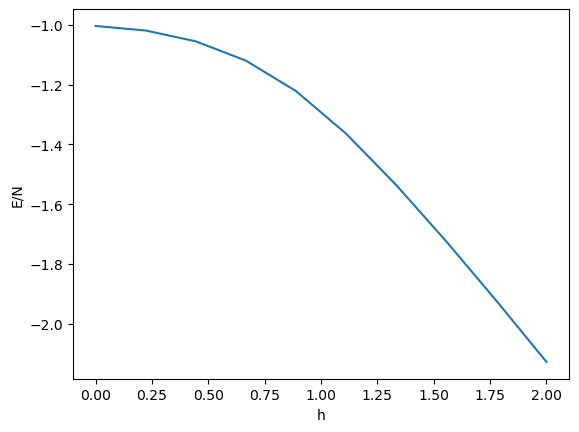

In [9]:
plt.errorbar(hy, (e)/N, yerr=(v_e)/N)
plt.xlabel("h")
plt.ylabel("E/N")

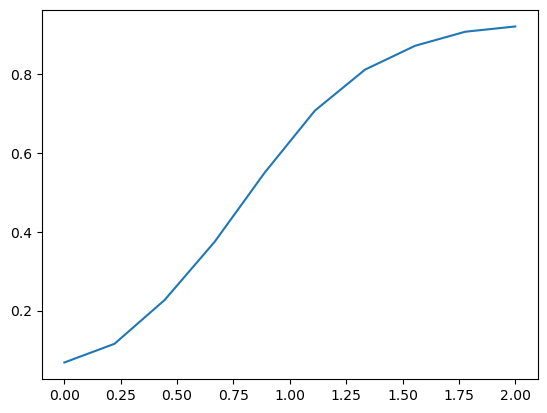

In [10]:
plt.plot(hy,-np.gradient(e/N, hy))

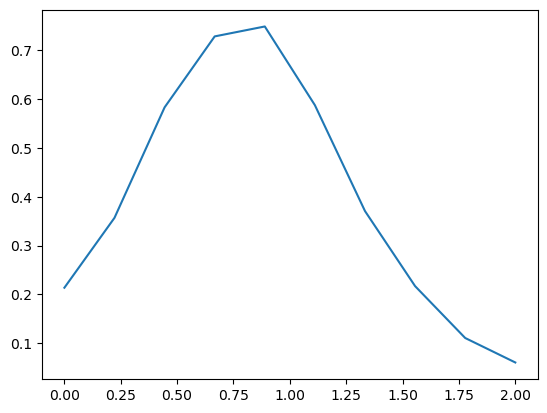

In [11]:
plt.plot(hy,np.gradient(-np.gradient(e/N, hy), hy))
#plt.plot(hy,np.gradient(-np.gradient(e1/N, hy), hy))

In [ ]:
plt.plot(hy[2:10], (m[2:10]))
#plt.plot(hy, m1)

Text(0.5, 1.0, 'L=4*2')

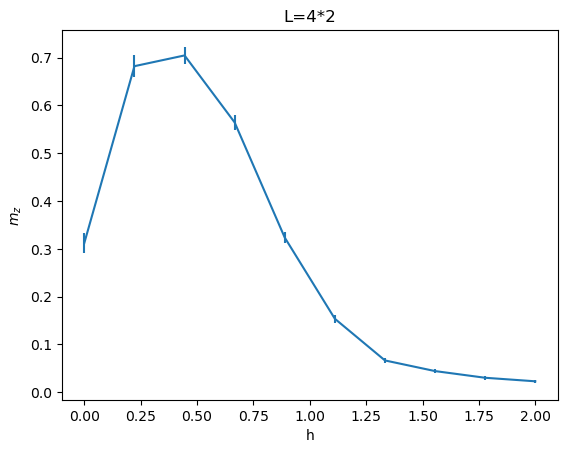

In [12]:
plt.errorbar(hy, (m), yerr=v_m)
plt.ylabel(r"$m_z$")
plt.xlabel("h")
plt.title("L=4*2")

In [ ]:
plt.plot(jnp.sqrt(v_m))

In [ ]:
plt.plot(hy,-np.gradient(m, hy))

In [ ]:
l = [4, 6, 8, 10]
n_l = len(l)

In [ ]:
Jz = 1
del_Jz = 0.0
grid = 5
ygrid = 20
Jx = jnp.linspace(0, 1, grid)
del_Jx = 0.0
hy = jnp.linspace(0, 2, ygrid)

In [ ]:
train_samples, test_samples = 2048, 32768
chunk_size = 1024
n_iter = 100

In [ ]:
def fss(Lx, Ly, Jz, del_Jz, Jx, del_Jx, hy, grid, train_samples, test_samples, chunk_size, n_iter):
    N = Lx*Ly

    basis = jnp.array([

    [1.0,0.0],

    [0.0,1.0],

    ])

    custom_edges = [

        (0, 0, [1.0,0.0], 0),

        (0, 0, [0.0,1.0], 1),

    ]

    g = Lattice(basis_vectors=basis, pbc=True, extent=[Lx,Ly],

        custom_edges=custom_edges)

    hi = nk.hilbert.Spin(s=1/2, N=g.n_nodes)
    #m_z = sum([sigmaz(hi,i) for i in g.nodes()])/g.n_nodes
    #m_z = sum([sigmaz(hi,i)*sigmaz(hi,j) for (i,j) in g.edges()])/g.n_nodes
    m_z = sum([sigmaz(hi,i)*sigmaz(hi,(i+g.n_nodes//2)%N) for i in range((g.n_nodes)-1)])/g.n_nodes

    symmetries = g.translation_group()
    #symmetries = g.automorphisms()
    #symmetries = g.point_group
    #symmetries = g.space_group
    feature_dims = (8,8,8,8)
    num_layers = 4

    

    model = nk.models.GCNN(symmetries=symmetries,features=feature_dims,layers=num_layers, param_dtype="complex")
    #model = nk.models.RBMSymm(symmetries=symmetries, alpha=4, param_dtype="complex")
    #model = nk.models.ARNNDense(hilbert=hi, layers=num_layers, features=feature_dims, param_dtype="complex")
    #model = nk.models.ARNNConv1D(hilbert=hi,  layers=num_layers, features=feature_dims, kernel_size=10, param_dtype="complex")
    #model = nk.models.tensor_networks.MPSPeriodic(hilbert=hi, bond_dim=20, param_dtype="complex")

    sampler = nk.sampler.MetropolisLocal(hi)
    vstate = nk.vqs.MCState(sampler, model, n_samples=train_samples, chunk_size=chunk_size)

    # Then we create an optimiser from the standard library.
    # You can also use optax.
    #optimizer = nk.optimizer.Adam(learning_rate=0.05)
    #optimizer = nk.optimizer.Momentum(learning_rate=0.005)
    #optimizer = nk.optimizer.AdaGrad(learning_rate=0.05)
    #optimizer = nk.optimizer.RmsProp(learning_rate=0.05)
    optimizer = nk.optimizer.Sgd(learning_rate=0.05)

    holo = True if nk.utils.is_probably_holomorphic(vstate._apply_fun,
                                 vstate.parameters,
                                 vstate.samples,
                                 model_state = vstate.model_state) == True else False

    preconditioner = nk.optimizer.SR(diag_shift=0.05, holomorphic = holo)

    e_gs = jnp.zeros((n_l, grid, ygrid), dtype='float64')
    em_e_gs = jnp.zeros((n_l, grid, ygrid), dtype='float64')
    data_m_z = jnp.zeros((n_l, grid, ygrid), dtype='float64')
    em_m_z = jnp.zeros((n_l, grid, ygrid), dtype='float64')
    #e_gs = jnp.zeros((n_l, grid, ygrid))
    #m_z = jnp.zeros((n_l, grid, ygrid))
    for j in range(grid):
        for k in range(ygrid):
            hamiltonian =  H_compass(Jz, del_Jz, Jx, del_Jx, hy[i], hi, g)
            if i == 1:
                vstate.init_parameters()
            vstate.n_samples = train_samples
            gs = nk.driver.VMC(hamiltonian, optimizer, variational_state=vstate,preconditioner=preconditioner)

            log=nk.logging.RuntimeLog()
            gs.run(n_iter=n_iter,out=log)
            vstate.n_samples = test_samples
            tmp_e_gs = vstate.expect(hamiltonian)
            tmp_mz = vstate.expect(m_z)
            e_gs = e_gs.at[i,j,k].set((tmp_e_gs.mean).real)
            em_e_gs = em_e_gs.at[i,j,k].set((tmp_e_gs.error_of_mean).real)
            data_m_z = data_m_z.at[i,j,k].set((tmp_mz.mean).real)
            em_m_z = em_m_z.at[i,j,k].set((tmp_mz.error_of_mean).real)

    return [e_gs, em_e_gs, data_m_z, em_m_z]

In [ ]:
e_gs = jnp.zeros((n_l, grid, ygrid), dtype='float64')
em_e_gs = jnp.zeros((n_l, grid, ygrid), dtype='float64')
data_m_z = jnp.zeros((n_l, grid, ygrid), dtype='float64')
em_m_z = jnp.zeros((n_l, grid, ygrid), dtype='float64')

In [ ]:
for i in range(n_l):
    Lx, Ly = l[i],2
    N = Lx*Ly
    N = Lx*Ly

    basis = jnp.array([

        [1.0,0.0],

        [0.0,1.0],

    ])

    custom_edges = [

        (0, 0, [1.0,0.0], 0),

        (0, 0, [0.0,1.0], 1),

    ]

    g = Lattice(basis_vectors=basis, pbc=True, extent=[Lx,Ly],

        custom_edges=custom_edges)

    hi = nk.hilbert.Spin(s=1/2, N=g.n_nodes)
    #m_z = sum([sigmaz(hi,i) for i in g.nodes()])/g.n_nodes
    #m_z = sum([sigmaz(hi,i)*sigmaz(hi,j) for (i,j) in g.edges()])/g.n_nodes
    m_z = sum([sigmaz(hi,i)*sigmaz(hi,(i+g.n_nodes//2)%N) for i in range((g.n_nodes)-1)])/g.n_nodes

    symmetries = g.translation_group()
    #symmetries = g.automorphisms()
    #symmetries = g.point_group
    #symmetries = g.space_group
    feature_dims = (8,8,8,8)
    num_layers = 4

    

    model = nk.models.GCNN(symmetries=symmetries,features=feature_dims,layers=num_layers, param_dtype="complex")
    #model = nk.models.RBMSymm(symmetries=symmetries, alpha=4, param_dtype="complex")
    #model = nk.models.ARNNDense(hilbert=hi, layers=num_layers, features=feature_dims, param_dtype="complex")
    #model = nk.models.ARNNConv1D(hilbert=hi,  layers=num_layers, features=feature_dims, kernel_size=10, param_dtype="complex")
    #model = nk.models.tensor_networks.MPSPeriodic(hilbert=hi, bond_dim=20, param_dtype="complex")

    sampler = nk.sampler.MetropolisLocal(hi)
    vstate = nk.vqs.MCState(sampler, model, n_samples=train_samples, chunk_size=chunk_size)

    # Then we create an optimiser from the standard library.
    # You can also use optax.
    #optimizer = nk.optimizer.Adam(learning_rate=0.05)
    #optimizer = nk.optimizer.Momentum(learning_rate=0.005)
    #optimizer = nk.optimizer.AdaGrad(learning_rate=0.05)
    #optimizer = nk.optimizer.RmsProp(learning_rate=0.05)
    optimizer = nk.optimizer.Sgd(learning_rate=0.05)

    holo = True if nk.utils.is_probably_holomorphic(vstate._apply_fun,
                                 vstate.parameters,
                                 vstate.samples,
                                 model_state = vstate.model_state) == True else False

    preconditioner = nk.optimizer.SR(diag_shift=0.05, holomorphic = holo)

    for j in range(grid):
        for k in range(ygrid):
            hamiltonian =  H_compass(Jz, del_Jz, Jx[j], del_Jx, hy[k], hi, g)
            #if i == 1:
            vstate.init_parameters()
            vstate.n_samples = train_samples
            gs = nk.driver.VMC(hamiltonian, optimizer, variational_state=vstate,preconditioner=preconditioner)

            log=nk.logging.RuntimeLog()
            gs.run(n_iter=n_iter,out=log)
            vstate.n_samples = test_samples
            tmp_e_gs = vstate.expect(hamiltonian)
            tmp_mz = vstate.expect(m_z)
            e_gs = e_gs.at[i,j,k].set((tmp_e_gs.mean).real)
            em_e_gs = em_e_gs.at[i,j,k].set((tmp_e_gs.error_of_mean).real)
            data_m_z = data_m_z.at[i,j,k].set((tmp_mz.mean).real)
            em_m_z = em_m_z.at[i,j,k].set((tmp_mz.error_of_mean).real)

In [ ]:
d = [fss(i) for i in Lx]

In [ ]:
d[0][0].shape

In [ ]:
grid = 20
h = jnp.linspace(0, 2, grid)
N = [8,10,12]

In [ ]:
[plt.errorbar(h, d[i][0]/N[i], yerr=d[i][1]/N[i]) for i in range(3)]
plt.xlabel("h")
plt.ylabel("E/N")

In [ ]:
[plt.errorbar(h, d[i][2], yerr=np.sqrt(d[i][3])) for i in range(3)]
plt.xlabel("h")
plt.ylabel(r"$m_z$")

In [ ]:
[plt.plot(h, d[i][3]/N[i]) for i in range(3)]

In [ ]:
Lx, Ly = 10, 2
N = Lx*Ly

In [ ]:
basis = jnp.array([

    [1.0,0.0],

    [0.0,1.0],

])

custom_edges = [

    (0, 0, [1.0,0.0], 0),

    (0, 0, [0.0,1.0], 1),

]

g = Lattice(basis_vectors=basis, pbc=True, extent=[Lx,Ly],

    custom_edges=custom_edges)

g.draw();
#print(g.n_nodes)

#print(len(g.edges(filter_color=0)))

#print(len(g.edges(filter_color=1)))

print(g.edges(filter_color=0))
print(list(set(g.edges(filter_color=1))))

In [ ]:
sym = nk.utils.group.PermutationGroup(g.translation_group(), degree = 20)

In [ ]:
sym.irrep_matrices()

In [ ]:
def com_tab(Lx,Ly,N):
    x_bonds = []
    z_bonds = []
    for i in range(N):
        if (i+1)%Ly == 0:
            x_bonds.append([i, (i+1)%Ly + (i-Ly+1)])
        else:
            x_bonds.append([i, (i+1)%N])
        if (i>=N-Ly):
            z_bonds.append([i, (i+Lx-1)%Lx])
        else:
            z_bonds.append([i, (i+Lx-1)%N])
    return x_bonds, z_bonds

In [ ]:
g = nk.graph.Hypercube(length=Lx, n_dim=2, pbc=True)

In [ ]:
hi = nk.hilbert.Spin(s=1/2, N=g.n_nodes)
m_z = sum([sigmaz(hi,i) for i in g.nodes()])/g.n_nodes

In [ ]:
def H_compass(K, del_k, delta, del_delta, h, com_int):
    hamiltonian = nk.operator.LocalOperator(hi)
    x_b, z_b = com_int
    for site in g.nodes():
        ix,jx = x_b[site]
        iz,jz = z_b[site]
        hamiltonian = hamiltonian - K * sigmaz(hi, iz)@sigmaz(hi, jz) - delta * sigmax(hi, ix)@sigmax(hi, jx) - h * sigmay(hi, site) - del_k * sigmaz(hi,site) - del_delta * sigmax(hi, site)
    return hamiltonian

In [ ]:
symmetries = g.translation_group()
#symmetries = g.automorphisms()
#symmetries = g.point_group
#symmetries = g.space_group
feature_dims = (8,8,8,8)
num_layers = 4

In [ ]:
grid = 20
theta = jnp.linspace(0,jnp.pi/2,grid)
K = jnp.cos(theta)
del_K = 0
del_delta = 0
delta = jnp.sin(theta)
h = 1
e_gs0 = jnp.zeros((grid), dtype='complex128')
for i in range(grid):
    hamiltonian =  H_compass(K[i], del_K, delta[i], del_delta, h)
    #model = FFN(alpha=1)
    model = nk.models.GCNN(symmetries=symmetries,features=feature_dims,layers=num_layers)
    #model = nk.models.RBMSymm(symmetries=symmetries, alpha=1)
    sampler = nk.sampler.MetropolisLocal(hi)
    vstate = nk.vqs.MCState(sampler, model, n_samples=2048)

    # Then we create an optimiser from the standard library.
    # You can also use optax.
    optimizer = nk.optimizer.Sgd(learning_rate=0.05)

    # build the optimisation driver
    gs = nk.driver.VMC(hamiltonian, optimizer, variational_state=vstate,preconditioner=nk.optimizer.SR(diag_shift=0.01))

    # run the driver for 300 iterations. This will display a progress bar
    # by default.

    log=nk.logging.RuntimeLog()
    gs.run(n_iter=100,out=log)
    e_gs0 = e_gs0.at[i].set(log.data["Energy"].Mean[-1])

In [ ]:
J = 1
del_J = 0.01
delta = 0
del_del = 0.0
grid = 20
h = jnp.linspace(0, 2, grid)

In [ ]:
model = nk.models.GCNN(symmetries=symmetries,features=feature_dims,layers=num_layers, param_dtype="complex")
#model = nk.models.RBMSymm(symmetries=symmetries, alpha=4, param_dtype="complex")
sampler = nk.sampler.MetropolisLocal(hi)
vstate = nk.vqs.MCState(sampler, model ,n_samples=1024)

# Then we create an optimiser from the standard library.
# You can also use optax.
optimizer = nk.optimizer.Sgd(learning_rate=0.05)

holo = True if nk.utils.is_probably_holomorphic(vstate._apply_fun,
                                 vstate.parameters,
                                 vstate.samples,
                                 model_state = vstate.model_state) == True else False

preconditioner = nk.optimizer.SR(diag_shift=0.05, holomorphic = holo)

In [ ]:
e_gs = jnp.zeros((grid), dtype='float64')
var_e_gs = jnp.zeros((grid), dtype='float64')
data_m_z = jnp.zeros((grid), dtype='float64')
var_m_z = jnp.zeros((grid), dtype='float64')
for i in range(grid):
    hamiltonian =  H_compass(J, del_J, delta, del_del, h[i])
    #vstate.init_parameters()
    #vstate.n_samples = 5024
    gs = nk.driver.VMC(hamiltonian, optimizer, variational_state=vstate,preconditioner=preconditioner)

    log=nk.logging.RuntimeLog()
    gs.run(n_iter=100,out=log)
    #vstate.n_samples = 40000
    tmp_e_gs = vstate.expect(hamiltonian)
    e_gs = e_gs.at[i].set((tmp_e_gs.mean).real)
    var_e_gs = var_e_gs.at[i].set((tmp_mz.variance).real)
    tmp_mz = vstate.expect(m_z)
    data_m_z = data_m_z.at[i].set((tmp_mz.mean).real)
    var_m_z = var_m_z.at[i].set((tmp_mz.variance).real)

In [ ]:
plt.plot(h, (e_gs)/N)
plt.xlabel("h")
plt.ylabel("E/N")

In [ ]:
plt.plot(h,np.gradient(e_gs, np.diff(h)[0]))
plt.plot(h,np.gradient(e_gs, h))

In [ ]:
plt.errorbar(h[0:-1], (data_m_z[0:-1]), yerr=(var_m_z[0:-1]))
plt.ylabel(r"$m_z$")
plt.xlabel("h")
plt.title("L=4*2")

In [ ]:
plt.plot(h,-np.gradient(data_m_z, h))

In [ ]:
grid = 20
theta = jnp.linspace(0,jnp.pi/2,grid)
gamma = jnp.linspace(0,jnp.pi/2,grid)
e_gs0 = jnp.zeros((grid, grid), dtype='complex128')
for i in range(grid):
    for j in range(grid):
        hamiltonian =  H_compass(jnp.cos(theta[i]), jnp.sin(theta[i]), gamma[j], com_tab(Lx,Ly,N))
        #model = FFN(alpha=1)
        model = nk.models.GCNN(symmetries=symmetries,features=feature_dims,layers=num_layers)
        #model = nk.models.RBMSymm(symmetries=symmetries, alpha=1)
        sampler = nk.sampler.MetropolisLocal(hi)
        vstate = nk.vqs.MCState(sampler, model, n_samples=1024)

        # Then we create an optimiser from the standard library.
        # You can also use optax.
        optimizer = nk.optimizer.Sgd(learning_rate=0.05)

        # build the optimisation driver
        gs = nk.driver.VMC(hamiltonian, optimizer, variational_state=vstate,preconditioner=nk.optimizer.SR(diag_shift=0.01))

        # run the driver for 300 iterations. This will display a progress bar
        # by default.

        log=nk.logging.RuntimeLog()
        gs.run(n_iter=100,out=log)
        e_gs0 = e_gs0.at[i,j].set(log.data["Energy"].Mean[-1])

In [ ]:
[plt.plot(theta, (e_gs0[:,i]).real/N) for i in range(grid)]
plt.xlabel(r"$\theta$")
plt.ylabel("E/N")

In [ ]:
[plt.plot(theta, (e_gs0[i]).real/N) for i in range(grid)]

In [ ]:
[plt.plot(theta, (e_gs0[i]).real/N) for i in range(grid)]

In [ ]:
l = [4,5,6,7,8,9,10]
n_l = len(l)

In [ ]:
grid = 5
ygrid = 20
Jx = jnp.linspace(0, 1, grid)
del_Jx = 0.0
hy = jnp.linspace(0, 2, ygrid)

In [ ]:
with open('netket_l_4-10.pickle', 'rb') as f:
    e_gs, em_e_gs, data_m_z, em_m_z = pickle.load(f)

In [ ]:
[[plt.plot(hy, e_gs[i,j,:]) for i in range(1)] for j in range(grid)]

In [ ]:
[[plt.plot(hy,-np.gradient(e_gs[i,j,:], hy)) for i in range(1)] for j in range(grid)]

In [ ]:
[[plt.plot(hy,np.gradient(-np.gradient(e_gs[i,j,:], hy), hy), label= "%d" %l[i]) for i in range(n_l)] for j in range(1)]
plt.legend()

<h1>Magnetization</h1>

In [ ]:
[[plt.plot(hy, data_m_z[i,j,:]) for i in [3]] for j in range(grid)]